In [ ]:
import numpy as np
import pandas as pd 
import tensorflow  as tf
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn as sk
import random  
from sklearn.preprocessing import LabelEncoder, FunctionTransformer,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, s, LeaveOneOut
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import regularizers 

from tensorflow.keras.initializers import HeNormal

import time



In [88]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


## Assignment 1 
- Spotify Classification- Can we predict if it is a high neutral or low amount of valence(positivity)
- Customer Personality Analysis- Campaign Receptivness

## Data Cleaning for Customer Perfomance Analysis and Spotify 
- Load The Two data sets 
- Data Clean if needed 
- Split into training and testing set


In [89]:
#Loading Dataset for CSV 
spotify_df=pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
marketing_df=pd.read_csv("marketing_campaign.csv",sep="\t") 


In [90]:
# Encoding Some of the Categorical variables
#Spotify 
# One hot encode Keys
spotify_df = pd.get_dummies(spotify_df, columns=['key'],dtype=int) 



# Label Encoding for mode 
mode_mapping = {'Major': 0, 'Minor': 1}

spotify_df['mode'] = spotify_df['mode'].map(mode_mapping)


#Marketing Campaign 
# Creating are "target class"
marketing_df['AcceptedAny'] = (marketing_df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',"Response"]].sum(axis=1) > 0).astype(int)

# One hot encoding marital status
marketing_df['Marital_Status'] = marketing_df['Marital_Status'].replace('Alone', 'Single') 
marketing_df['Marital_Status'] = marketing_df['Marital_Status'].replace('Married', 'Together') 
marketing_df['Marital_Status'] = marketing_df['Marital_Status'].replace('YOLO', 'Absurd')
marketing_df = pd.get_dummies(marketing_df, columns=['Marital_Status'],dtype=int) 
#Dropping the first one to avoid multi collinearity


# Target Encoding for Education 
education_mapping = {
    'Basic': 0, 
    'Graduation': 1, 
    "2n Cycle":2,
    "Master":2,
    "Phd":3}

marketing_df['Education'] = marketing_df['Education'].map(education_mapping)

# Binning the decades of age 
bins = [float('-inf'), 1920, 1940, 1960, 1980, float('inf')]
bin_labels = [ '-1919', '1920-1939', '1940-1959', '1960-1979', '1980-' ]


marketing_df['birth_eras'] = pd.cut(marketing_df['Year_Birth'], bins=bins, labels=bin_labels)


marketing_df = pd.get_dummies(marketing_df,columns=['birth_eras'], prefix='year',dtype=int) 



# Converting "Vaelance" into four classes 
bins = [-1, 20, 40, 60, 80, 101]
labels = [0, 1, 2, 3, 4]  # Numeric labels corresponding to each bin

# Use pd.cut to bin the data and assign the numeric labels directly
spotify_df['valence_%'] = pd.cut(spotify_df['valence_%'], bins=bins, labels=labels, right=True)



In [91]:
#Drops Uneeded Categories and rows with null values, and the first column from one hot encoding

#Spotify Removal Of Uneeded 
spotify_df.drop(columns=["track_name","artist(s)_name","in_deezer_playlists","artist_count","released_day","released_year","released_month",'key_A'],axis =1,inplace=True) 
spotify_df.dropna(inplace=True)

#Marketing Removal Of Uneeded 
marketing_df.drop(columns=["ID","Year_Birth","Marital_Status_Absurd",'year_-1919',"Dt_Customer",'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response',"Z_CostContact","Z_Revenue"],axis =1,inplace=True) 
marketing_df.dropna(inplace=True)


In [92]:

spotify_df = spotify_df.apply(pd.to_numeric,errors='coerce') 
marketing_df=marketing_df.apply(pd.to_numeric,errors='coerce')  

spotify_df.dropna(inplace=True) 
marketing_df.dropna(inplace=True)





In [93]:
#Splitting Dataframe into X and y 
#Setting Seed 
random.seed(123456)

x_spotify=spotify_df.drop(columns=["valence_%"])
y_spotify=spotify_df["valence_%"]
x_marketing= marketing_df.drop(columns=['AcceptedAny'])
y_marketing=marketing_df['AcceptedAny']


'''
train_spotify_df, test_spotify_df = train_test_split(spotify_df, test_size=0.2, random_state=10) 
train_marketing_df, test_marketing_df = train_test_split(marketing_df, test_size=0.2, random_state=10) 

train_spotify_df.reset_index(drop=True, inplace=True)
test_spotify_df.reset_index(drop=True, inplace=True) 
train_marketing_df.reset_index(drop=True, inplace=True)
test_marketing_df.reset_index(drop=True, inplace=True)
'''

'\ntrain_spotify_df, test_spotify_df = train_test_split(spotify_df, test_size=0.2, random_state=10) \ntrain_marketing_df, test_marketing_df = train_test_split(marketing_df, test_size=0.2, random_state=10) \n\ntrain_spotify_df.reset_index(drop=True, inplace=True)\ntest_spotify_df.reset_index(drop=True, inplace=True) \ntrain_marketing_df.reset_index(drop=True, inplace=True)\ntest_marketing_df.reset_index(drop=True, inplace=True)\n'

In [94]:
# Creates the Scaling Preproccesor for X Values
standard_categories = ['in_spotify_playlists', 'in_spotify_charts', 'streams',
                           'in_apple_playlists', 'in_apple_charts',
                           'in_deezer_charts', 'in_shazam_charts', 'bpm']

percentage_categories = [ 'danceability_%', 'energy_%', 'acousticness_%', 
                      'instrumentalness_%', 'liveness_%']

# Define the transformers
standard_scaler = StandardScaler()
def divide_by_100(X):
    return X / 100 

percentage_scaler = FunctionTransformer(divide_by_100)

preprocessor_spotify = ColumnTransformer(
    transformers=[
        ('standard', standard_scaler, standard_categories), 
        ('percentage', percentage_scaler, percentage_categories)         
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False  
)

# Scaling categories (Based on Training/Testing)
standard_categories = ['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       ] 

preprocessor_marketing = ColumnTransformer(
    transformers=[
        ('standard', standard_scaler, standard_categories),          
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False
)




## K Nearest Neighbors
For K Nearest Neighbors, we will be focusing on looking into how the hyper paramater of K (how many neighbors we should consider) alters

In [95]:
'''
Significantly too long to train and test 
%%cython
import numpy as np
cimport numpy as np

# Function that computes the Euclidean distance between two numpy arrays
def custom_distance(np.ndarray[np.float64_t, ndim=1] x, np.ndarray[np.float64_t, ndim=1] y):
    cdef np.ndarray[np.float64_t, ndim=1] diff = x - y  # element-wise subtraction
    return np.linalg.norm(diff)  # compute the norm (Euclidean distance)

    '''


'\nSignificantly too long to train and test \n%%cython\nimport numpy as np\ncimport numpy as np\n\n# Function that computes the Euclidean distance between two numpy arrays\ndef custom_distance(np.ndarray[np.float64_t, ndim=1] x, np.ndarray[np.float64_t, ndim=1] y):\n    cdef np.ndarray[np.float64_t, ndim=1] diff = x - y  # element-wise subtraction\n    return np.linalg.norm(diff)  # compute the norm (Euclidean distance)\n\n    '

In [96]:
knn = KNeighborsClassifier()

# Create a pipeline that first preprocesses the data and then applies KNN
knn_pipeline_spotify = Pipeline(steps=[
    ('preprocessor', preprocessor_spotify),  # Apply the preprocessor
    ('knn', knn)  # Apply KNN after preprocessing
])

knn_pipeline_marketing= Pipeline(steps=[
    ('preprocessor', preprocessor_marketing),  # Apply the preprocessor
    ('knn', knn)  # Apply KNN after preprocessing
]) 

In [97]:
# Hyper Paramater Testing


hyperparamaters = {
    'knn__n_neighbors': [3, 5, 7, 9, 11,13,15,17,19,21,23],  # Number of neighbors to test
    'knn__weights': ['uniform', 'distance'],  # Weighting methods
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
## Looking into Marketing Data Set



grid_search_market = GridSearchCV(knn_pipeline_marketing, hyperparamaters, cv=cv, scoring='accuracy',return_train_score=True)
grid_search_market.fit(x_marketing, y_marketing)

## LOoking into the Spotify Data Set 


grid_search_spotify = GridSearchCV(knn_pipeline_spotify, hyperparamaters, cv=cv, scoring='neg_mean_squared_error',return_train_score=True) 
grid_search_spotify.fit(x_spotify, y_spotify)





GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['in_spotify_playlists',
                                                                          'in_spotify_charts',
                                                                          'streams',
                                                                          'in_apple_playlists',
                                                                          'in_apple_charts',
                                                                          'in_deezer_charts',
                                                                          'in_shaz...
                                                                        ('percentage',
                                                                         FunctionTransformer(func=<function divide_by_100 at 0x000002A32A1F7F40>),
                                                                         ['danceability_%',
                                                                          'energy_%',
                                                                          'acousticness_%',
                                                                          'instrumentalness_%',
                                                                          'liveness_%'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23],
                         'knn__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

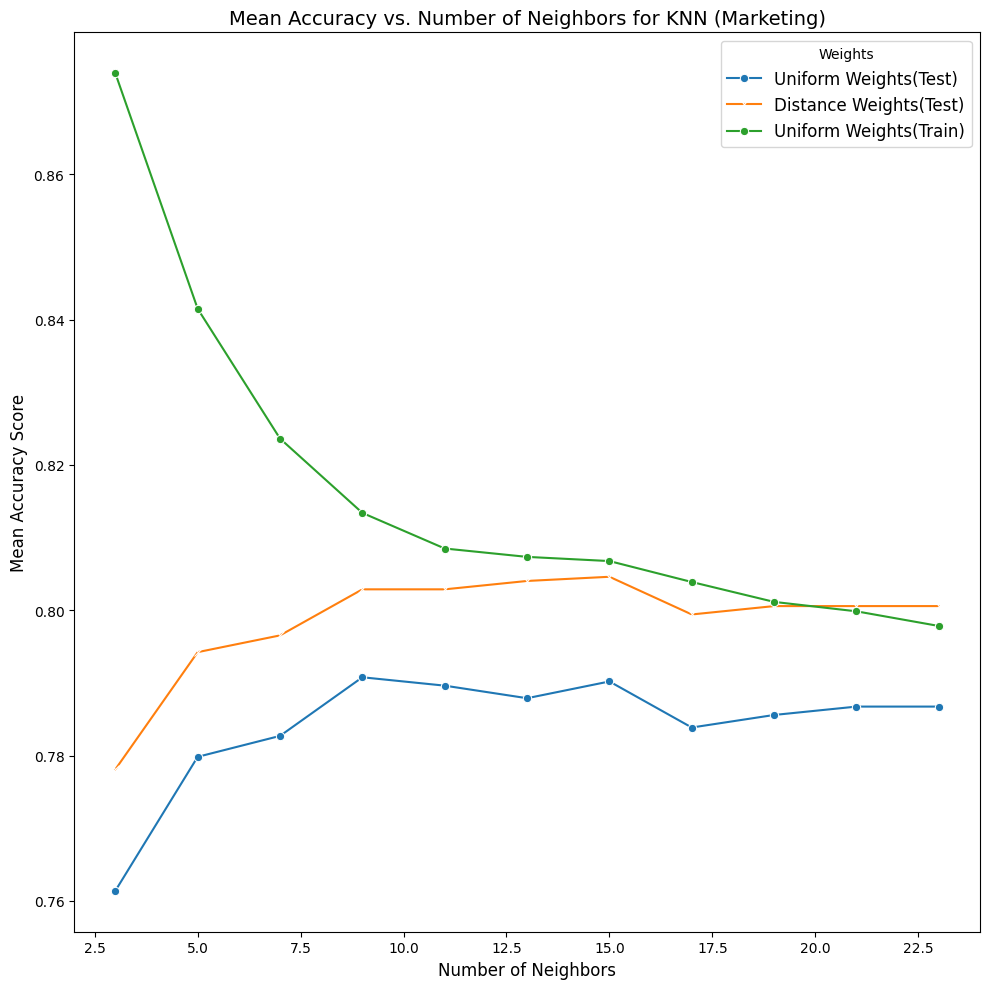

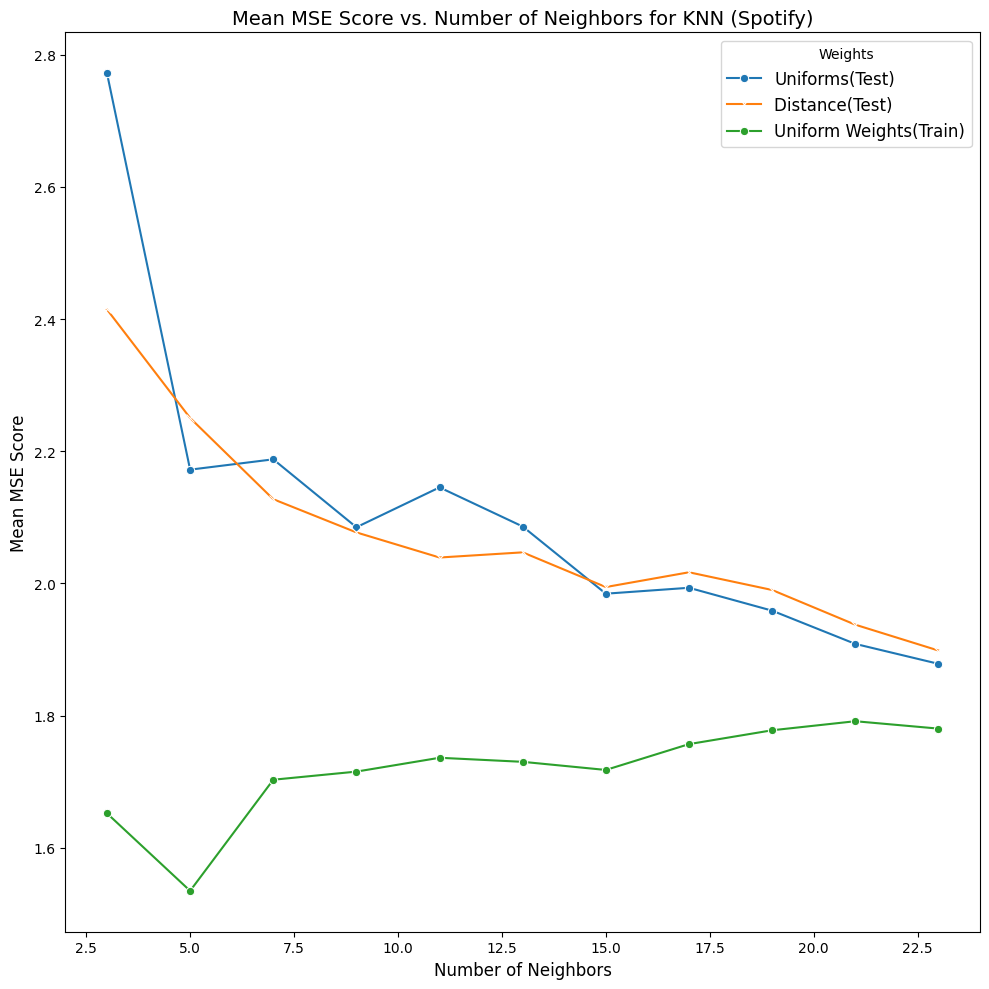

In [98]:
#Investgate Hyper Paramaters with plots 


# Convert GridSearchCV results for Marketing Data to a DataFrame
marketingres_df = pd.DataFrame(grid_search_market.cv_results_)


# Convert GridSearchCV results for Spotify Data to a DataFrame
spotifyres_df = pd.DataFrame(grid_search_spotify.cv_results_) 
spotifyres_df['mean_test_score'] =spotifyres_df['mean_test_score']*-1 
spotifyres_df['mean_train_score'] =spotifyres_df['mean_train_score']*-1


uniform_df = marketingres_df[marketingres_df['param_knn__weights'] == 'uniform']
distance_df = marketingres_df[marketingres_df['param_knn__weights'] == 'distance']

# Set the figure size for the plot
plt.figure(figsize=(10, 10)) 


# Create the Seaborn line plot
sns.lineplot(data=uniform_df, x='param_knn__n_neighbors', y='mean_test_score', label='Uniform Weights(Test)', marker='o')
sns.lineplot(data=distance_df, x='param_knn__n_neighbors', y='mean_test_score', label='Distance Weights(Test)', marker='x') 
sns.lineplot(data=uniform_df, x='param_knn__n_neighbors', y='mean_train_score', label='Uniform Weights(Train)', marker='o') 


# Add labels and title
plt.title('Mean Accuracy vs. Number of Neighbors for KNN (Marketing)', fontsize=14)
plt.xlabel('Number of Neighbors', fontsize=12)
plt.ylabel('Mean Accuracy Score', fontsize=12)
plt.legend(title='Weights', fontsize=12)


# Save the plot to a file (e.g., as a PNG image)
plt.tight_layout()
plt.savefig('knn_test_score_vs_neighbors_marketing.png')  # Save as PNG file 
plt.show()








uniform_df = spotifyres_df[spotifyres_df['param_knn__weights'] == 'uniform']
distance_df = spotifyres_df[spotifyres_df['param_knn__weights'] == 'distance']

# Set the figure size for the plot
plt.figure(figsize=(10, 10)) 


# Create the Seaborn line plot
sns.lineplot(data=uniform_df, x='param_knn__n_neighbors', y='mean_test_score', label='Uniforms(Test)', marker='o')
sns.lineplot(data=distance_df, x='param_knn__n_neighbors', y='mean_test_score', label='Distance(Test) ', marker='x') 
sns.lineplot(data=uniform_df, x='param_knn__n_neighbors', y='mean_train_score', label='Uniform Weights(Train)', marker='o') 



# Add labels and title
plt.title('Mean MSE Score vs. Number of Neighbors for KNN (Spotify)', fontsize=14)
plt.xlabel('Number of Neighbors', fontsize=12)
plt.ylabel('Mean MSE Score', fontsize=12)
plt.legend(title='Weights', fontsize=12)


# Save the plot to a file (e.g., as a PNG image)
plt.tight_layout()
plt.savefig('knn_test_score_vs_neighbors_spotify.png')  # Save as PNG file 
plt.show()





plt.close()

In [ ]:
final_knn = KNeighborsClassifier(n_neighbors=1,weights='distance')

# Create a pipeline that first preprocesses the data and then applies KNN
knn_pipeline_spotify = Pipeline(steps=[
    ('preprocessor', preprocessor_spotify),  # Apply the preprocessor
    ('knn', final_knn)  # Apply KNN after preprocessing
])
final_knn = KNeighborsClassifier(n_neighbors=15,weights='distance')
knn_pipeline_marketing= Pipeline(steps=[
    ('preprocessor', preprocessor_marketing),  # Apply the preprocessor
    ('knn', final_knn)  # Apply KNN after preprocessing
]) 

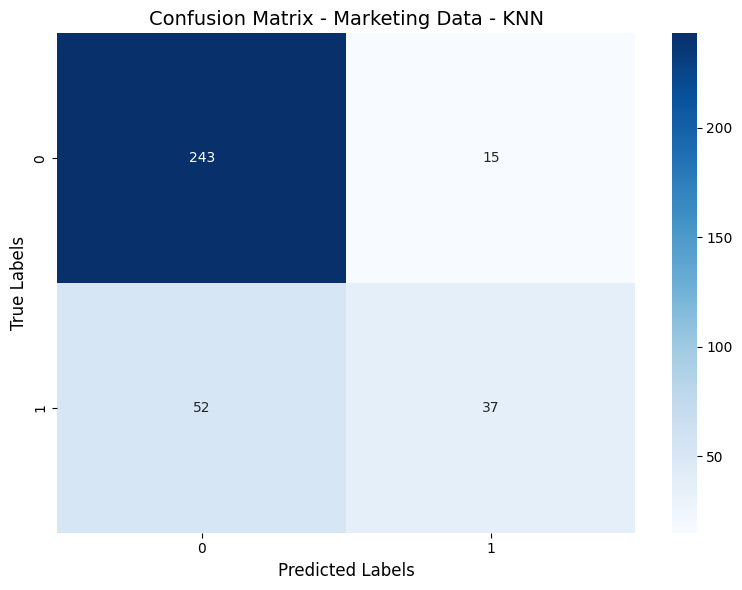

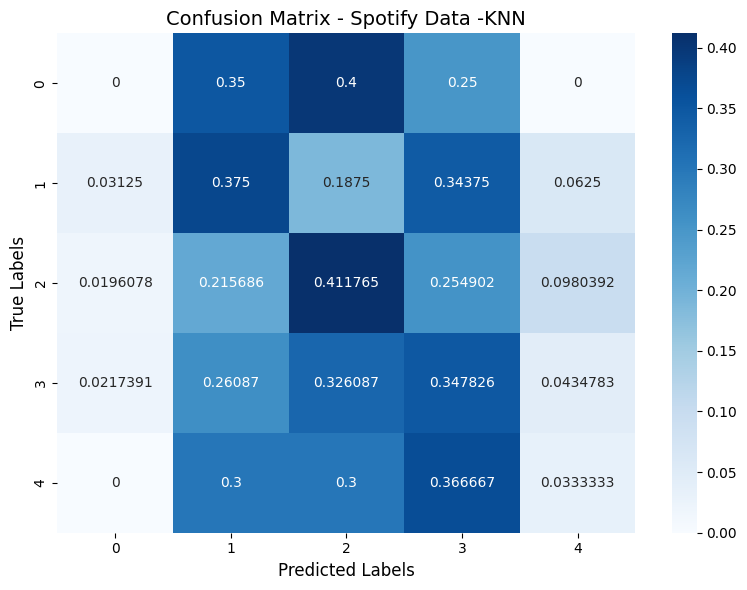

In [100]:
#Final Decided Classifier  

## Looking into Marketing Data Set

x_train,x_test,y_train,y_test=train_test_split(x_marketing,y_marketing, test_size=0.2, random_state=10)

knn_pipeline_marketing.fit(x_train, y_train) 
y_pred= knn_pipeline_marketing.predict(x_test)


# Calculate the confusion matrix
cm_marketing = confusion_matrix(y_test, y_pred) 
cmn_marketing = cm_marketing.astype('float') / cm_marketing.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm_marketing, annot=True, fmt='g', cmap='Blues', xticklabels=knn_pipeline_marketing.classes_, yticklabels=knn_pipeline_marketing.classes_)
plt.title('Confusion Matrix - Marketing Data - KNN', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Save the plot to a file (e.g., as a PNG image)
plt.tight_layout()
plt.savefig('confusion_matrix_marketing_knn.png')  # Save as PNG file 
plt.show() 


## LOoking into the Spotify Data Set 
x_train,x_test,y_train,y_test=train_test_split(x_spotify,y_spotify, test_size=0.2, random_state=10)  
knn_pipeline_spotify.fit(x_train, y_train) 
y_pred= knn_pipeline_spotify.predict(x_test)
  

cm_spotify = confusion_matrix(y_test, y_pred) 
cmn_spotify = cm_spotify.astype('float') / cm_spotify.sum(axis=1)[:, np.newaxis]


# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cmn_spotify, annot=True, fmt='g', cmap='Blues', xticklabels=knn_pipeline_spotify.classes_, yticklabels=knn_pipeline_spotify.classes_)
plt.title('Confusion Matrix - Spotify Data -KNN', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12) 
# Save the plot to a file (e.g., as a PNG image)
plt.tight_layout()
plt.savefig('confusion_matrix_spotify_knn.png')  # Save as PNG file 
plt.show()


In [101]:
#Spotify MSE 
mse_knn = mean_squared_error(y_test, y_pred)

print(f"Mean squared Error (MSE) for Spotify data: {mse_knn:.4f}")

Mean squared Error (MSE) for Spotify data: 2.2514


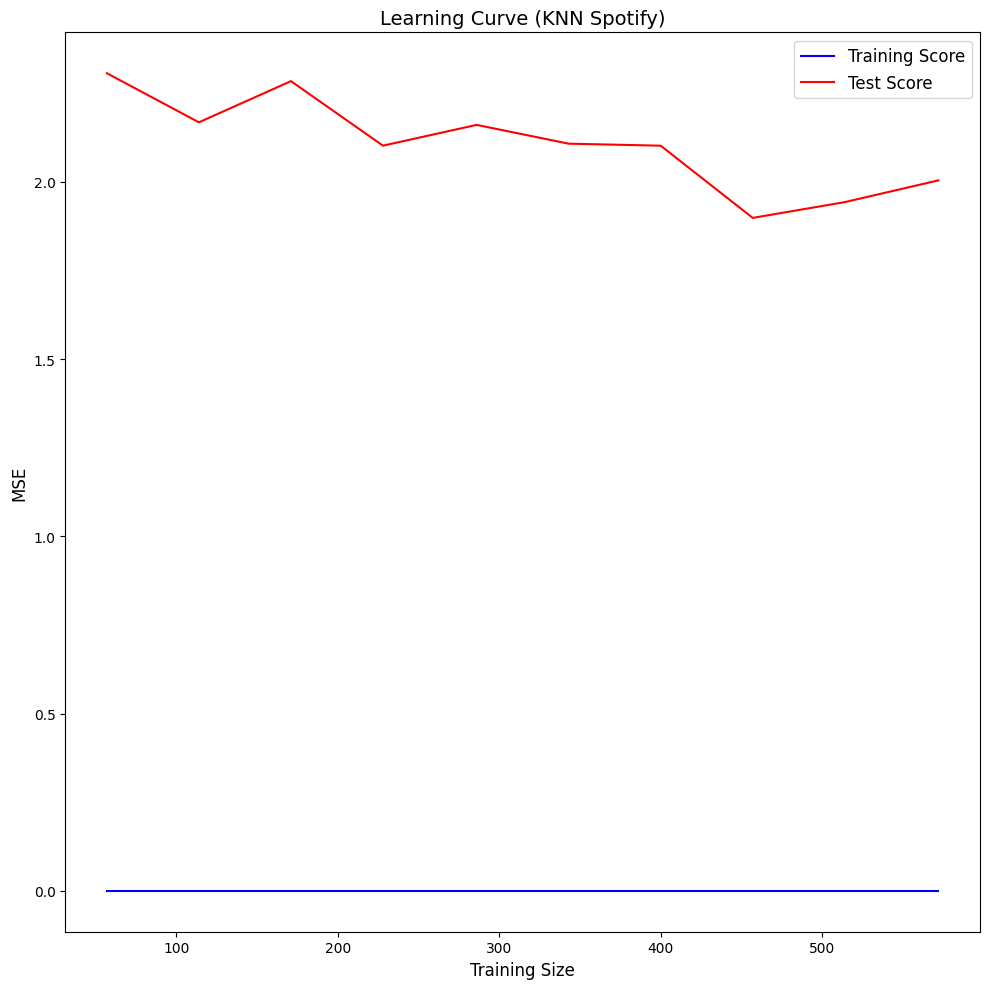

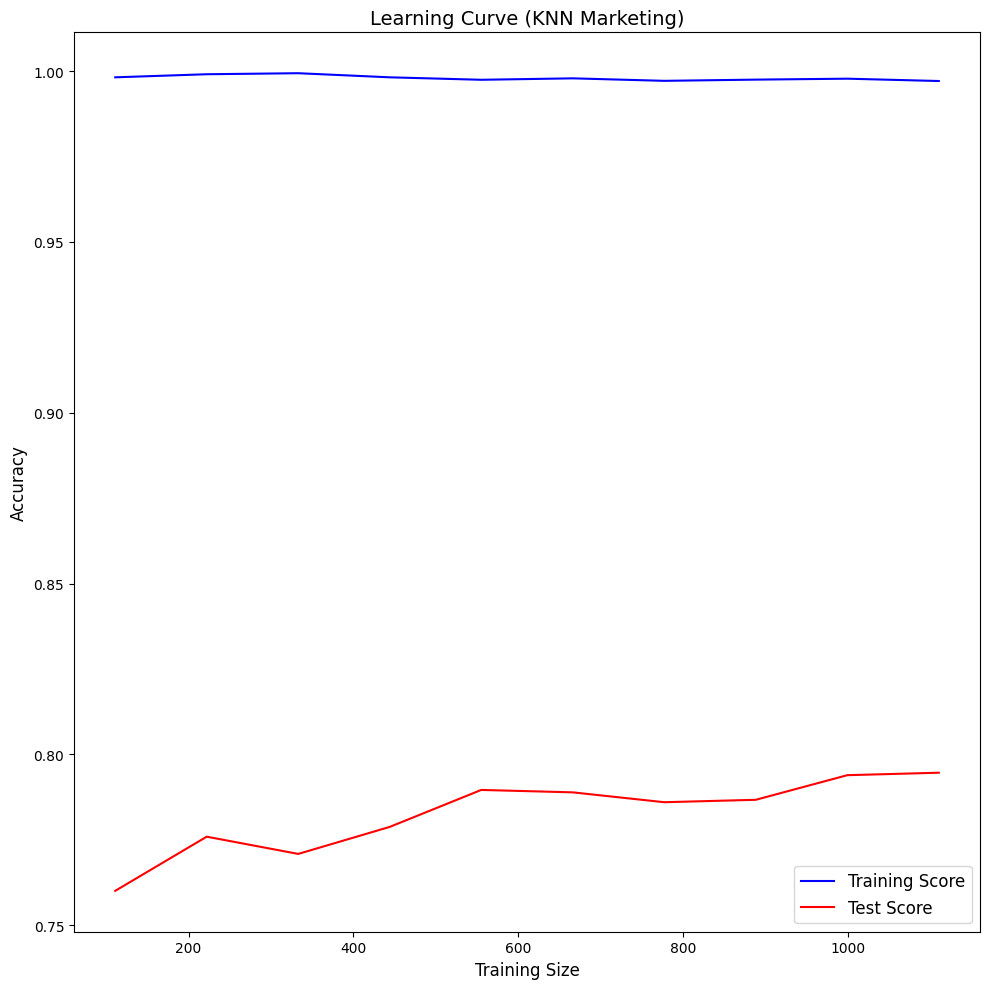

In [102]:
#Learning Curves Spotify
# 4. Use learning_curve to get training and test scores
x_train,x_test,y_train,y_test=train_test_split(x_spotify,y_spotify, test_size=0.2, random_state=10)  
train_sizes, train_scores, test_scores = learning_curve(
    knn_pipeline_spotify, x_train, y_train, 
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of training data
    scoring='neg_mean_squared_error',  # Use accuracy as the scoring metric
    n_jobs=-1  # Use all CPUs to speed up calculations 
    
)

# 5. Calculate the mean and standard deviation of the training and test scores
train_mean = train_scores.mean(axis=1)*-1
test_mean = test_scores.mean(axis=1)*-1


# 6. Plot the learning curve
plt.figure(figsize=(10, 10))


# Plot the training and test learning curves
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Test Score', color='red')

# Add labels and title
plt.title('Learning Curve (KNN Spotify)', fontsize=14)
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show() 

x_train,x_test,y_train,y_test=train_test_split(x_marketing,y_marketing, test_size=0.2, random_state=10)
train_sizes, train_scores, test_scores = learning_curve(
    knn_pipeline_marketing, x_train, y_train, 
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of training data
    scoring='accuracy',  # Use accuracy as the scoring metric
    n_jobs=-1  # Use all CPUs to speed up calculations
)

# 5. Calculate the mean and standard deviation of the training and test scores
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)


# 6. Plot the learning curve
plt.figure(figsize=(10, 10)) 


# Plot the training and test learning curves
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Test Score', color='red')

# Add labels and title
plt.title('Learning Curve (KNN Marketing)', fontsize=14)
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Neural Network 
Neural Network Planned Structure 

In [ ]:


def create_spotify_model(n_features=25, activation_function="relu", learning_rate=.001, num_neurons=128, layers=4):
    model = Sequential()

    # Initialize weights with He Normal for the first layer
    model.add(Dense(num_neurons, activation=activation_function, input_shape=(n_features,), kernel_initializer=HeNormal()))
    
    for a in range(layers - 1): 
        # Prevent num_neurons from becoming too small (<= 1)
        num_neurons = max(num_neurons // 2, 2)
        model.add(Dense(num_neurons, activation=activation_function,kernel_initializer=HeNormal()))  # Apply He Normal

    model.add(Dense(5, activation='softmax'))  # Softmax output layer

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',  # Mean Squared Error for multi-class classification (or use categorical cross-entropy)
                  metrics=['mse'])

    return model


def create_marketing_model(n_features=25, activation_function="relu", learning_rate=.0001, num_neurons=128, layers=5):
    model = Sequential()

    
    model.add(Dense(num_neurons, activation=activation_function, input_shape=(n_features,), kernel_initializer=HeNormal())) 

    for a in range(layers - 1): 
        # Prevent num_neurons from becoming too small (<= 1)
        if num_neurons > 8:
            num_neurons = max(num_neurons // 2, 2)  # Ensure neurons don't go below 2
        model.add(Dense(num_neurons, activation=activation_function, kernel_initializer=HeNormal()))  # Apply He Normal
        
    model.add(Dense(1, activation='sigmoid', kernel_initializer=HeNormal()))  # Sigmoid output layer

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',  
                  metrics=["accuracy"])

    return model


In [104]:
# Building and Training Neural Network 

#Choosing the best Neural Network activation_function

spotify_model_relu = create_spotify_model(activation_function="relu")
spotify_model_swish = create_spotify_model(activation_function="swish")


marketing_model_relu = create_marketing_model(activation_function="relu")
marketing_model_swish = create_marketing_model(activation_function="swish") 



normalization=MinMaxScaler()

c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:


spotifycv_relu_loss_train = []
spotifycv_swish_loss_train = []
spotifycv_relu_mse_train = []
spotifycv_swish_mse_train = []

spotifycv_relu_loss_val = []
spotifycv_swish_loss_val = []
spotifycv_relu_mse_val = []
spotifycv_swish_mse_val = []

X_train, X_test, y_train, y_test = train_test_split(x_spotify, y_spotify, test_size=0.2, random_state=42)

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for neurons in [512,256, 128, 64]:
    # Reset lists for each fold
    spotify_relu_loss_train = []
    spotify_swish_loss_train = []
    spotify_relu_mse_train = []
    spotify_swish_mse_train = []
    
    spotify_relu_loss_val = []
    spotify_swish_loss_val = []
    spotify_relu_mse_val = []
    spotify_swish_mse_val = []
    
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        # Split data into training and validation sets for the current fold
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Preprocess data
        X_train_fold = preprocessor_spotify.fit_transform(X_train_fold) 
        X_val_fold = preprocessor_spotify.transform(X_val_fold)

        #Normalize data 
        #X_train_fold = normalization.fit_transform(X_train_fold) 
        #X_val_fold = normalization.transform(X_val_fold)
          


        # Create models for each activation function
        spotify_model_relu = create_spotify_model(activation_function="relu",num_neurons=neurons)
        spotify_model_swish = create_spotify_model(activation_function="swish",num_neurons=neurons)


        # Train models with early stopping
        history_relu = spotify_model_relu.fit(X_train_fold, y_train_fold, epochs=100, batch_size=64, 
                                              verbose=0, validation_data=(X_val_fold, y_val_fold))
        history_swish = spotify_model_swish.fit(X_train_fold, y_train_fold, epochs=100, batch_size=64, 
                                                verbose=0, validation_data=(X_val_fold, y_val_fold))

        # Get training loss and MSE for both models
        loss_train_relu, mse_train_relu = spotify_model_relu.evaluate(X_train_fold, y_train_fold, verbose=0)
        loss_train_swish, mse_train_swish = spotify_model_swish.evaluate(X_train_fold, y_train_fold, verbose=0)

        # Append to the training lists
        spotify_relu_loss_train.append(loss_train_relu)
        spotify_swish_loss_train.append(loss_train_swish)
        spotify_relu_mse_train.append(mse_train_relu)
        spotify_swish_mse_train.append(mse_train_swish)

        # Get validation loss and MSE for both models
        loss_val_relu, mse_val_relu = spotify_model_relu.evaluate(X_val_fold, y_val_fold, verbose=0)
        loss_val_swish, mse_val_swish = spotify_model_swish.evaluate(X_val_fold, y_val_fold, verbose=0)

        # Append to the validation lists
        spotify_relu_loss_val.append(loss_val_relu)
        spotify_swish_loss_val.append(loss_val_swish)
        spotify_relu_mse_val.append(mse_val_relu)
        spotify_swish_mse_val.append(mse_val_swish)

    # Append the results of each fold to the final lists
    spotifycv_relu_loss_train.append(spotify_relu_loss_train)
    spotifycv_swish_loss_train.append(spotify_swish_loss_train)
    spotifycv_relu_mse_train.append(spotify_relu_mse_train)
    spotifycv_swish_mse_train.append(spotify_swish_mse_train)

    spotifycv_relu_loss_val.append(spotify_relu_loss_val)
    spotifycv_swish_loss_val.append(spotify_swish_loss_val)
    spotifycv_relu_mse_val.append(spotify_relu_mse_val)
    spotifycv_swish_mse_val.append(spotify_swish_mse_val)






c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Seq

In [106]:


marketingcv_relu_loss_train = []
marketingcv_swish_loss_train = []
marketingcv_relu_accuracy_train = []
marketingcv_swish_accuracy_train = []

marketingcv_relu_loss_val = []
marketingcv_swish_loss_val = []
marketingcv_relu_accuracy_val = []
marketingcv_swish_accuracy_val = []

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_marketing, y_marketing, test_size=0.2, random_state=42)

# Define Stratified KFold cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for neurons in [512,256, 128, 64]:
    # Reset lists for each fold
    marketing_relu_loss_train = []
    marketing_swish_loss_train = []
    marketing_relu_accuracy_train = []
    marketing_swish_accuracy_train = []
    
    marketing_relu_loss_val = []
    marketing_swish_loss_val = []
    marketing_relu_accuracy_val = []
    marketing_swish_accuracy_val = []
    
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        # Split data into training and validation sets for the current fold
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Preprocess data
        X_train_fold = preprocessor_marketing.fit_transform(X_train_fold)
        X_val_fold = preprocessor_marketing.transform(X_val_fold)

        # Create models for each activation function
        marketing_model_relu = create_marketing_model(activation_function="relu",num_neurons=neurons)
        marketing_model_swish = create_marketing_model(activation_function="swish",num_neurons=neurons)


        # Train models with early stopping
        history_relu = marketing_model_relu.fit(X_train_fold, y_train_fold, epochs=100, batch_size=64, 
                                                verbose=0, validation_data=(X_val_fold, y_val_fold))
        history_swish = marketing_model_swish.fit(X_train_fold, y_train_fold, epochs=100, batch_size=64, 
                                                  verbose=0, validation_data=(X_val_fold, y_val_fold))

        # Get training loss and accuracy for both models
        loss_train_relu, accuracy_train_relu = marketing_model_relu.evaluate(X_train_fold, y_train_fold, verbose=0)
        loss_train_swish, accuracy_train_swish = marketing_model_swish.evaluate(X_train_fold, y_train_fold, verbose=0)

        # Append to the training lists
        marketing_relu_loss_train.append(loss_train_relu)
        marketing_swish_loss_train.append(loss_train_swish)
        marketing_relu_accuracy_train.append(accuracy_train_relu)
        marketing_swish_accuracy_train.append(accuracy_train_swish)

        # Get validation loss and accuracy for both models
        loss_val_relu, accuracy_val_relu = marketing_model_relu.evaluate(X_val_fold, y_val_fold, verbose=0)
        loss_val_swish, accuracy_val_swish = marketing_model_swish.evaluate(X_val_fold, y_val_fold, verbose=0)

        # Append to the validation lists
        marketing_relu_loss_val.append(loss_val_relu)
        marketing_swish_loss_val.append(loss_val_swish)
        marketing_relu_accuracy_val.append(accuracy_val_relu)
        marketing_swish_accuracy_val.append(accuracy_val_swish)

    # Append the results of each fold to the final lists
    marketingcv_relu_loss_train.append(marketing_relu_loss_train)
    marketingcv_swish_loss_train.append(marketing_swish_loss_train)
    marketingcv_relu_accuracy_train.append(marketing_relu_accuracy_train)
    marketingcv_swish_accuracy_train.append(marketing_swish_accuracy_train)

    marketingcv_relu_loss_val.append(marketing_relu_loss_val)
    marketingcv_swish_loss_val.append(marketing_swish_loss_val)
    marketingcv_relu_accuracy_val.append(marketing_relu_accuracy_val)
    marketingcv_swish_accuracy_val.append(marketing_swish_accuracy_val)


c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Seq

[[4.867827892303467, 4.90928316116333, 4.866165637969971], [4.857448101043701, 4.899308204650879, 4.851028919219971], [4.845766544342041, 4.885794162750244, 4.838343620300293], [4.815389156341553, 4.858246803283691, 4.813180923461914]]


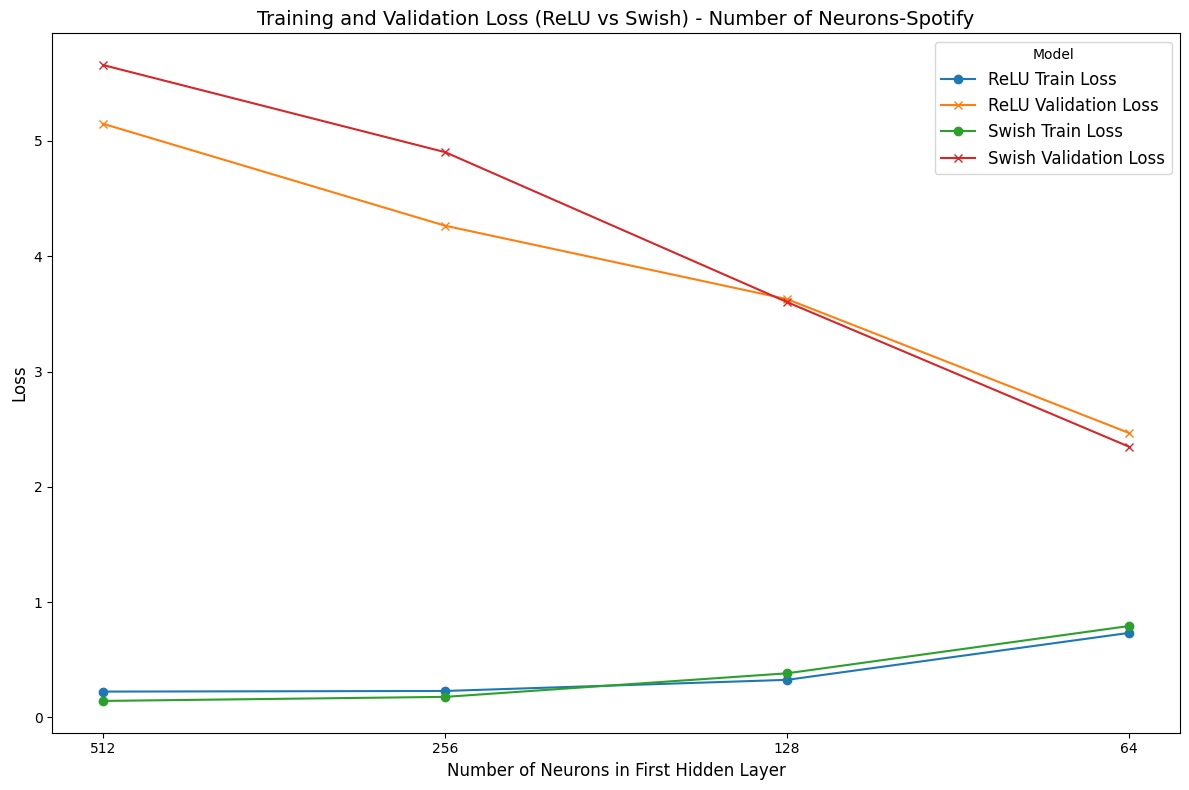

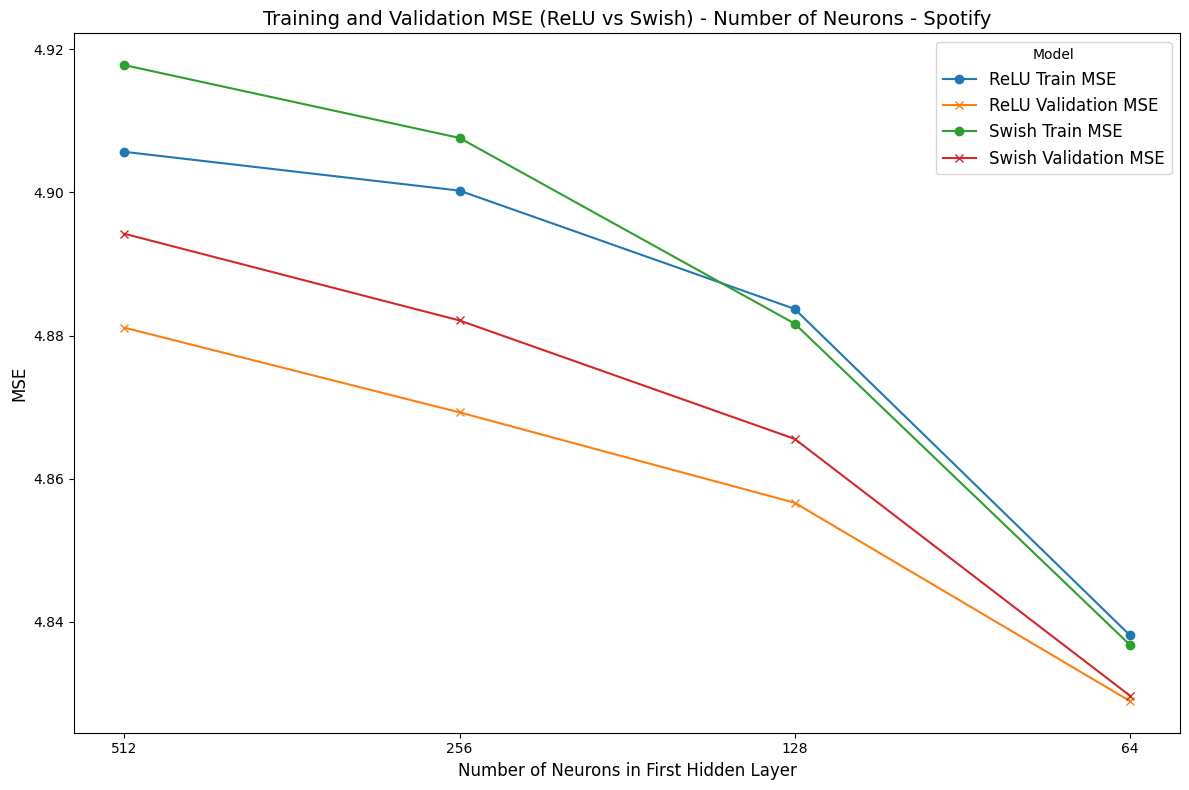

In [107]:
# Average the results across neurons (axis=1)
def average_results(results):
    return np.mean(results, axis=1)  # Change axis=1 to average over neurons

neurons = [512,256, 128, 64]  # List of neurons, to be used as x-tick labels

# Plotting the Loss for ReLU and Swish models
plt.figure(figsize=(12, 8))

# Plot ReLU model: Training vs Validation Loss
plt.plot(average_results(spotifycv_relu_loss_train), label="ReLU Train Loss", marker='o')
plt.plot(average_results(spotifycv_relu_loss_val), label="ReLU Validation Loss", marker='x')
 
print(spotifycv_relu_mse_val)
# Plot Swish model: Training vs Validation Loss
plt.plot(average_results(spotifycv_swish_loss_train), label="Swish Train Loss", marker='o')
plt.plot(average_results(spotifycv_swish_loss_val), label="Swish Validation Loss", marker='x')

# Set x-ticks to represent the neurons list
plt.xticks(ticks=np.arange(len(neurons)), labels=neurons)

plt.title("Training and Validation Loss (ReLU vs Swish) - Number of Neurons-Spotify", fontsize=14)
plt.xlabel("Number of Neurons in First Hidden Layer", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(title="Model", fontsize=12)

plt.tight_layout() 
plt.savefig("relu_vs_swish_loss_spotify_neurons.png")
plt.show()

# Plotting MSE for ReLU and Swish models
plt.figure(figsize=(12, 8))

# ReLU Model Training vs Validation MSE
plt.plot(average_results(spotifycv_relu_mse_train), label="ReLU Train MSE", marker='o')
plt.plot(average_results(spotifycv_relu_mse_val), label="ReLU Validation MSE", marker='x')

# Swish Model Training vs Validation MSE
plt.plot(average_results(spotifycv_swish_mse_train), label="Swish Train MSE", marker='o')
plt.plot(average_results(spotifycv_swish_mse_val), label="Swish Validation MSE", marker='x')
average_results(spotifycv_swish_mse_train)
# Set x-ticks to represent the neurons list
plt.xticks(ticks=np.arange(len(neurons)), labels=neurons)

plt.title("Training and Validation MSE (ReLU vs Swish) - Number of Neurons - Spotify", fontsize=14)
plt.xlabel("Number of Neurons in First Hidden Layer", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.legend(title="Model", fontsize=12)

plt.tight_layout() 
plt.savefig("relu_vs_swish_mse_neurons.png")
plt.show()

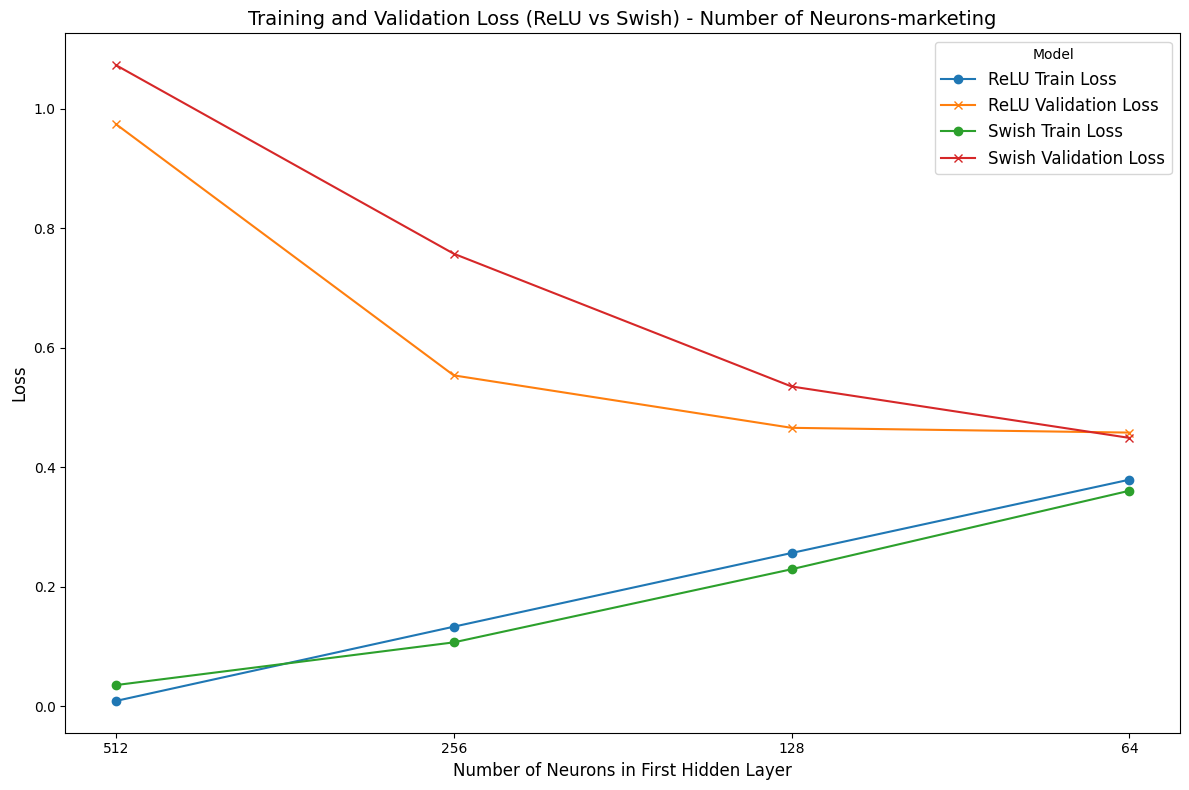

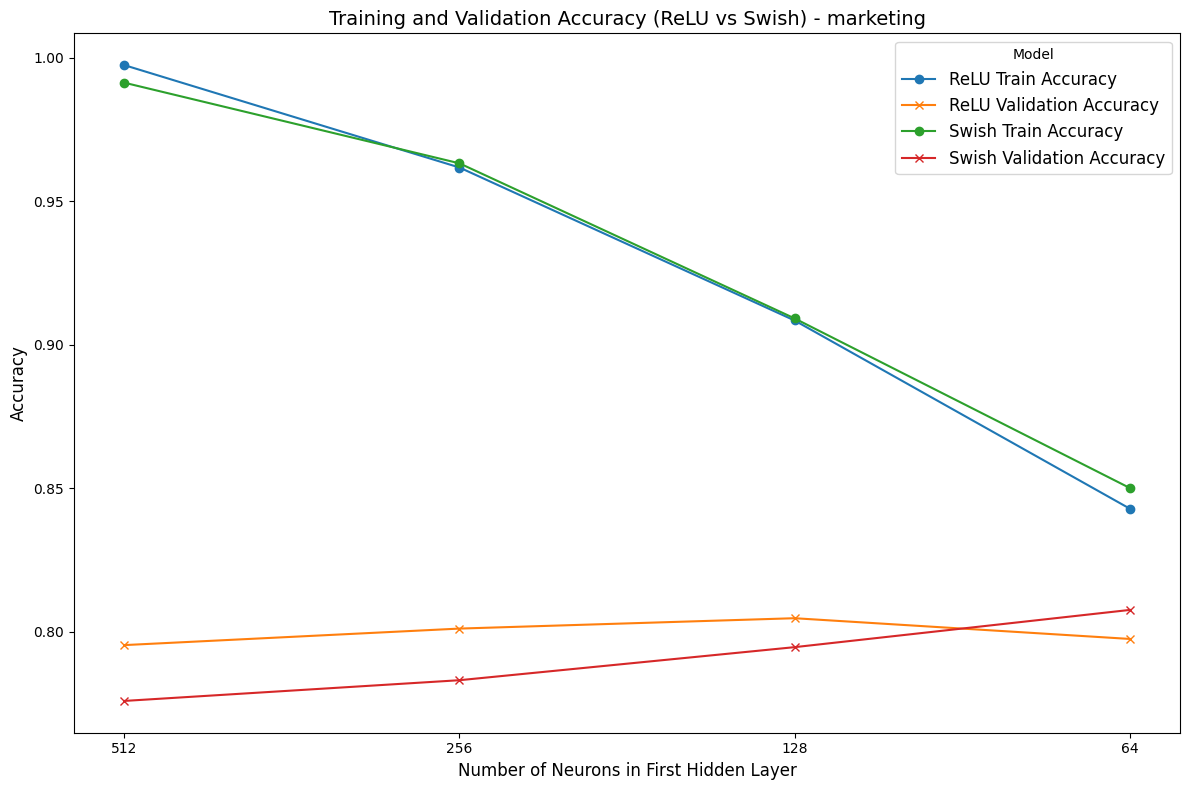

In [108]:
# Average the results across neurons (axis=1)
def average_results(results):
    return np.mean(results, axis=1)  # Change axis=1 to average over neurons

neurons = [512,256, 128, 64]  # List of neurons, to be used as x-tick labels

# Plotting the Loss for ReLU and Swish models (Marketing Data)
plt.figure(figsize=(12, 8))

# Plot ReLU model: Training vs Validation Loss
plt.plot(average_results(marketingcv_relu_loss_train), label="ReLU Train Loss", marker='o')
plt.plot(average_results(marketingcv_relu_loss_val), label="ReLU Validation Loss", marker='x')

# Plot Swish model: Training vs Validation Loss
plt.plot(average_results(marketingcv_swish_loss_train), label="Swish Train Loss", marker='o')
plt.plot(average_results(marketingcv_swish_loss_val), label="Swish Validation Loss", marker='x')

# Set x-ticks to represent the neurons list
plt.xticks(ticks=np.arange(len(neurons)), labels=neurons)

plt.title("Training and Validation Loss (ReLU vs Swish) - Number of Neurons-marketing", fontsize=14)
plt.xlabel("Number of Neurons in First Hidden Layer", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(title="Model", fontsize=12)

plt.tight_layout() 
plt.savefig("relu_vs_swish_loss_marketing_neurons.png")
plt.show()

# Plotting Accuracy for ReLU and Swish models (Marketing Data)
plt.figure(figsize=(12, 8))

# ReLU Model Training vs Validation Accuracy
plt.plot(average_results(marketingcv_relu_accuracy_train), label="ReLU Train Accuracy", marker='o')
plt.plot(average_results(marketingcv_relu_accuracy_val), label="ReLU Validation Accuracy", marker='x')

# Swish Model Training vs Validation Accuracy
plt.plot(average_results(marketingcv_swish_accuracy_train), label="Swish Train Accuracy", marker='o')
plt.plot(average_results(marketingcv_swish_accuracy_val), label="Swish Validation Accuracy", marker='x')

# Set x-ticks to represent the neurons list
plt.xticks(ticks=np.arange(len(neurons)), labels=neurons)

plt.title("Training and Validation Accuracy (ReLU vs Swish) - marketing", fontsize=14)
plt.xlabel("Number of Neurons in First Hidden Layer", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(title="Model", fontsize=12)

plt.tight_layout() 
plt.savefig("relu_vs_swish_accuracy_marketing_neurons.png")
plt.show()


c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


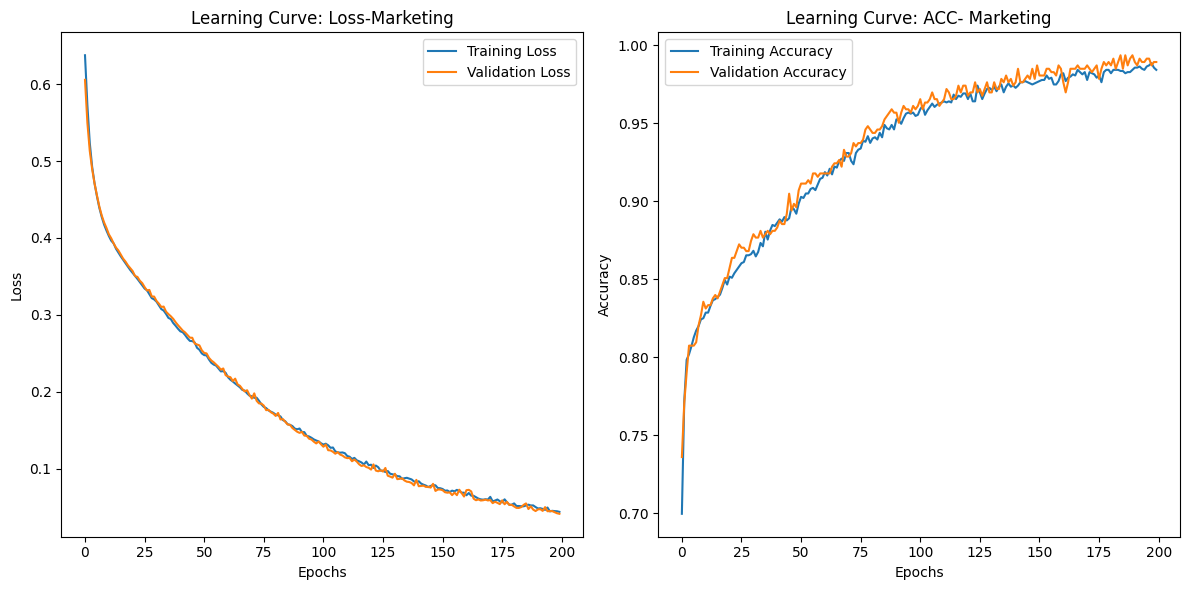

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [122]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_marketing, y_marketing, test_size=0.2, random_state=42)

# regularization 
        # Preprocess data
X_train = preprocessor_marketing.fit_transform(X_train)
X_test = preprocessor_marketing.transform(X_test)


# Create models for each activation function
marketing_model_swish = create_marketing_model(activation_function="swish",num_neurons=256)



# Train models with early stopping

history =marketing_model_swish.fit(X_train, y_train, epochs=200, batch_size=64, 
                                            verbose=0, validation_data=(X_val_fold, y_val_fold))  

# Extract training and validation losses and accuracies
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']  # Or another metric you specified
val_accuracy = history.history['val_accuracy']  # Or another metric you specified 

# Plot Losses
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Learning Curve: Loss-Marketing')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot (optional, for classification tasks)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve: ACC- Marketing')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout() 
plt.savefig('curve_marketing_neural.png')
plt.show() 
plt.close


c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[4.936033248901367, 4.936033725738525, 4.936033725738525, 4.833250999450684, 4.776051998138428, 4.776052951812744, 4.776054382324219, 4.776055335998535, 4.776057720184326, 4.776061058044434, 4.776064395904541, 4.776069641113281, 4.77607536315918, 4.776082992553711, 4.776090145111084, 4.776099681854248, 4.776109218597412, 4.776118755340576, 4.776129245758057, 4.7761430740356445, 4.776158332824707, 4.776172637939453, 4.776188373565674, 4.776206016540527, 4.776225566864014, 4.7762451171875, 4.7762651443481445, 4.776288986206055, 4.776310920715332, 4.7763352394104, 4.776360034942627, 4.776386737823486, 4.7764129638671875, 4.776439666748047, 4.776467800140381, 4.776496887207031, 4.776526927947998, 4.776558876037598, 4.776589393615723, 4.77662467956543, 4.77665901184082, 4.7766923904418945, 4.776723861694336, 4.776760101318359, 4.776795864105225, 4.776832103729248, 4.776870250701904, 4.776906490325928, 4.776944160461426, 4.776979446411133, 4.777016639709473, 4.7770538330078125, 4.77709293365

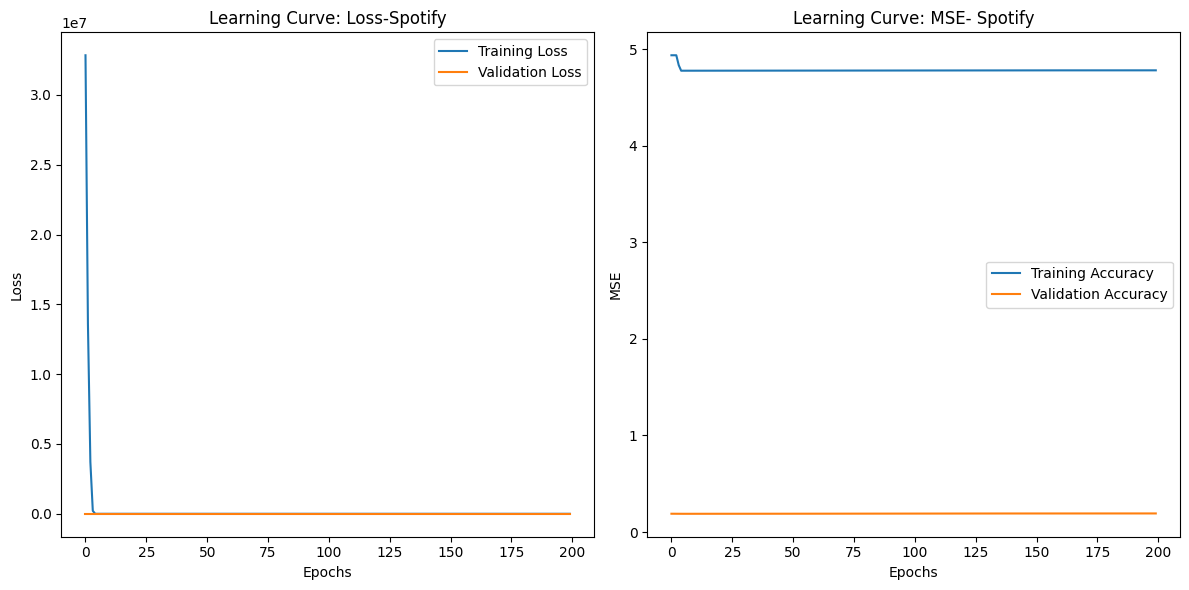

In [119]:
# Split data into training and testing sets 

X_train, X_test, y_train, y_test = train_test_split(x_spotify, y_spotify, test_size=0.2, random_state=42)

X_train_fold = preprocessor_spotify.fit_transform(X_train)
X_test = preprocessor_spotify.transform(X_test)

# Create models for each activation function
spotify_model_relu = create_spotify_model(activation_function="relu",num_neurons=64)



# Train models with early stopping

history =spotify_model_relu.fit(X_train, y_train, epochs=200, batch_size=64, 
                                            verbose=0, validation_data=(X_val_fold, y_val_fold)) 


# Extract training and validation losses and accuracies
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['mse']  # Or another metric you specified
val_accuracy = history.history['val_mse']  # Or another metric you specified 

print(train_accuracy)
# Plot Losses
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Learning Curve: Loss-Spotify')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot (optional, for classification tasks)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve: MSE- Spotify')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

plt.savefig('curve_marketing_spotify.png') 
plt.close()





## SVM


In [111]:
# Creating the SVM Pipeline 

svc = SVC(decision_function_shape='ovr')

# Create a pipeline that first preprocesses the data and then applies KNN
svm_pipeline_spotify = Pipeline(steps=[
    ('preprocessor', preprocessor_spotify),  # Apply the preprocessor
    ('svm', SVC(decision_function_shape='ovr'))  # Apply KNN after preprocessing
])

svm_pipeline_marketing= Pipeline(steps=[
    ('preprocessor', preprocessor_marketing),  # Apply the preprocessor
    ('svm', SVC(decision_function_shape='ovr'))  # Apply KNN after preprocessing
]) 

In [112]:
# Building and Training SVM 
# Hyper Paramater Testing

# Define the hyperparameter grid for SVM
hyperparamaters = {
    'svm__C': [.001,0.1, 1, 10, 25, 50, 100],  # Regularization parameter
    'svm__kernel': ['linear', 'poly', 'rbf'],  # Kernel functions 
    'svm__degree': [2],  # Test different polynomial degrees
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
## Looking into Marketing Data Set



grid_search_market_SVM = GridSearchCV(svm_pipeline_marketing, hyperparamaters, cv=cv, scoring='accuracy',return_train_score=True)
grid_search_market_SVM.fit(x_marketing, y_marketing)

## LOoking into the Spotify Data Set 


grid_search_spotify_SVM = GridSearchCV(svm_pipeline_spotify, hyperparamaters, cv=cv, scoring='neg_mean_squared_error',return_train_score=True) 
grid_search_spotify_SVM.fit(x_spotify, y_spotify)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['in_spotify_playlists',
                                                                          'in_spotify_charts',
                                                                          'streams',
                                                                          'in_apple_playlists',
                                                                          'in_apple_charts',
                                                                          'in_deezer_charts',
                                                                          'in_sha...
                                                                          'bpm']),
                                                                        ('percentage',
                                                                         FunctionTransformer(func=<function divide_by_100 at 0x000002A32A1F7F40>),
                                                                         ['danceability_%',
                                                                          'energy_%',
                                                                          'acousticness_%',
                                                                          'instrumentalness_%',
                                                                          'liveness_%'])])),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.001, 0.1, 1, 10, 25, 50, 100],
                         'svm__degree': [2],
                         'svm__kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True, scoring='neg_mean_squared_error')

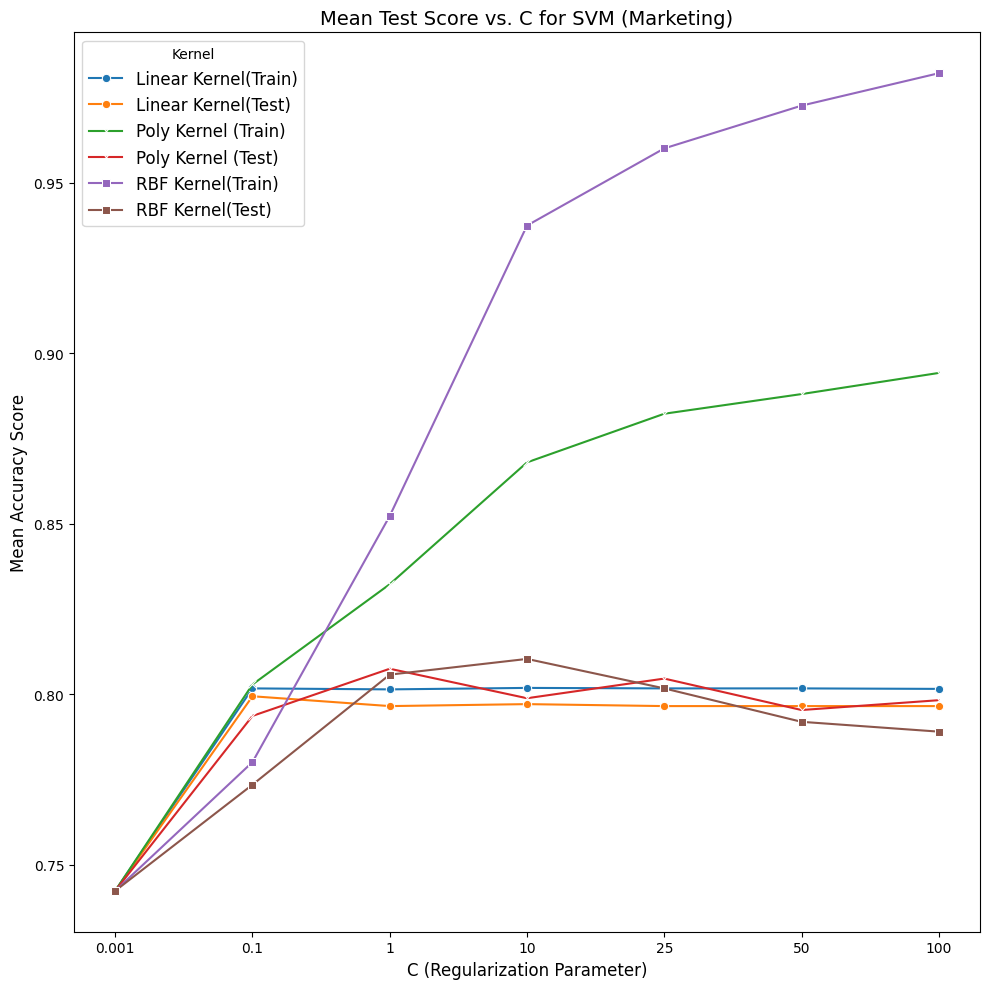

<Figure size 640x480 with 0 Axes>

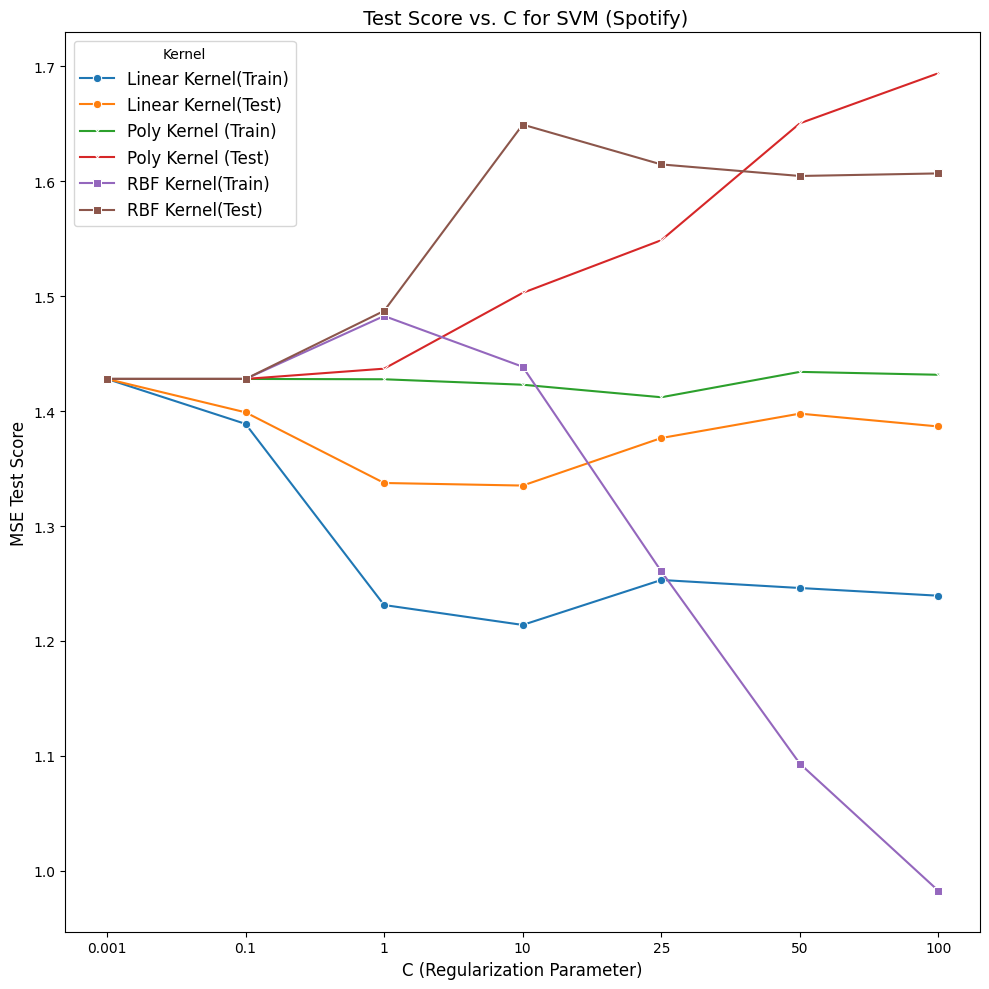

In [113]:
# For Marketing Data SVM
svmres_df = pd.DataFrame(grid_search_market_SVM.cv_results_)

# Map each C value to an evenly spaced position
c_values = [.001,0.1, 1, 10, 25, 50, 100]  # Original C values
c_position_map = {val: idx for idx, val in enumerate(c_values)}  # Map each C to an index
svmres_df['C_position'] = svmres_df['param_svm__C'].map(c_position_map)

# Filter out the results by kernel type
linear_df = svmres_df[svmres_df['param_svm__kernel'] == 'linear']
poly_df = svmres_df[svmres_df['param_svm__kernel'] == 'poly']
rbf_df = svmres_df[svmres_df['param_svm__kernel'] == 'rbf']

# Plotting for SVM GridSearch (Marketing)
plt.figure(figsize=(10, 10)) 


# Plot for linear kernel
sns.lineplot(data=linear_df, x='C_position', y='mean_train_score', label='Linear Kernel(Train)', marker='o') 
sns.lineplot(data=linear_df, x='C_position', y='mean_test_score', label='Linear Kernel(Test)', marker='o')

# Plot for poly kernel (with varying degrees)
for degree in [2]:
    poly_kernel_df = poly_df[poly_df['param_svm__degree'] == degree]
    sns.lineplot(data=poly_kernel_df, x='C_position', y='mean_train_score', label=f'Poly Kernel (Train)', marker='x')  
    sns.lineplot(data=poly_kernel_df, x='C_position', y='mean_test_score', label=f'Poly Kernel (Test)', marker='x') 
    

# Plot for rbf kernel
sns.lineplot(data=rbf_df, x='C_position', y='mean_train_score', label='RBF Kernel(Train)', marker='s') 
sns.lineplot(data=rbf_df, x='C_position', y='mean_test_score', label='RBF Kernel(Test)', marker='s')

# Update the x-axis with the actual C values as labels
plt.xticks(ticks=np.arange(len(c_values)), labels=c_values)

# Add labels and title
plt.title('Mean Test Score vs. C for SVM (Marketing)', fontsize=14)
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('Mean Accuracy Score', fontsize=12)
plt.legend(title='Kernel', fontsize=12)

# Save the plot to a file (e.g., as a PNG image)
plt.tight_layout()
plt.savefig('svm_test_score_vs_C_marketing.png')  # Save as PNG file 
plt.show()
plt.clf()


# For Spotify Data SVM 

svmres_df = pd.DataFrame(grid_search_spotify_SVM.cv_results_)

svmres_df['mean_test_score'] =svmres_df['mean_test_score']*-1 
svmres_df['mean_train_score'] =svmres_df['mean_train_score']*-1
# Map each C value to an evenly spaced position
svmres_df['C_position'] = svmres_df['param_svm__C'].map(c_position_map)

# Filter out the results by kernel type
linear_df = svmres_df[svmres_df['param_svm__kernel'] == 'linear']
poly_df = svmres_df[svmres_df['param_svm__kernel'] == 'poly']
rbf_df = svmres_df[svmres_df['param_svm__kernel'] == 'rbf']

# Plotting for SVM GridSearch (Spotify)
plt.figure(figsize=(10, 10))

# Plot for linear kernel
sns.lineplot(data=linear_df, x='C_position', y='mean_train_score', label='Linear Kernel(Train)', marker='o') 
sns.lineplot(data=linear_df, x='C_position', y='mean_test_score', label='Linear Kernel(Test)', marker='o')

# Plot for poly kernel (with varying degrees)
for degree in [2]:
    poly_kernel_df = poly_df[poly_df['param_svm__degree'] == degree]
    sns.lineplot(data=poly_kernel_df, x='C_position', y='mean_train_score', label=f'Poly Kernel (Train)', marker='x')  
    sns.lineplot(data=poly_kernel_df, x='C_position', y='mean_test_score', label=f'Poly Kernel (Test)', marker='x') 

# Plot for rbf kernel
sns.lineplot(data=rbf_df, x='C_position', y='mean_train_score', label='RBF Kernel(Train)', marker='s') 
sns.lineplot(data=rbf_df, x='C_position', y='mean_test_score', label='RBF Kernel(Test)', marker='s')

# Update the x-axis with the actual C values as labels
plt.xticks(ticks=np.arange(len(c_values)), labels=c_values)

# Add labels and title
plt.title(' Test Score vs. C for SVM (Spotify)', fontsize=14)
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('MSE Test Score', fontsize=12)
plt.legend(title='Kernel', fontsize=12)

# Save the plot to a file (e.g., as a PNG image)
plt.tight_layout()
plt.savefig('svm_test_score_vs_C_spotify.png')  # Save as PNG file 
plt.show()



In [114]:
#Best Solution 
svc = SVC(kernel='linear',C=10,decision_function_shape='ovr',class_weight='balanced')

# Create a pipeline that first preprocesses the data and then applies KNN
svm_pipeline_spotify = Pipeline(steps=[
    ('preprocessor', preprocessor_spotify),  # Apply the preprocessor
    ('svm', svc)  # Apply KNN after preprocessing
])

svc = SVC(kernel='rbf',C=10,decision_function_shape='ovr')
svm_pipeline_marketing= Pipeline(steps=[
    ('preprocessor', preprocessor_marketing),  # Apply the preprocessor
    ('svm', svc)  # Apply KNN after preprocessing
]) 

In [115]:




marketing_model_relu = create_marketing_model(activation_function="relu")
marketing_model_swish = create_marketing_model(activation_function="swish") 



c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Classes in Marketing dataset: [0 1]


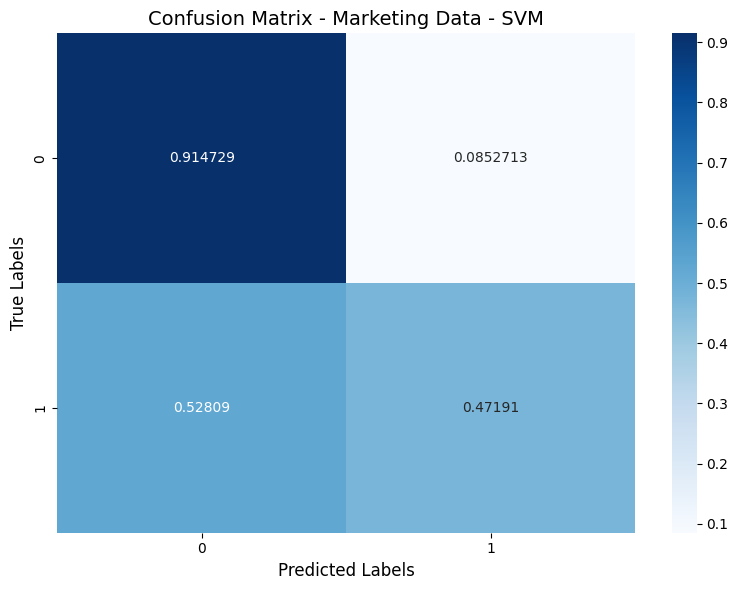

Classes in Spotify dataset: [0 1 2 3 4]


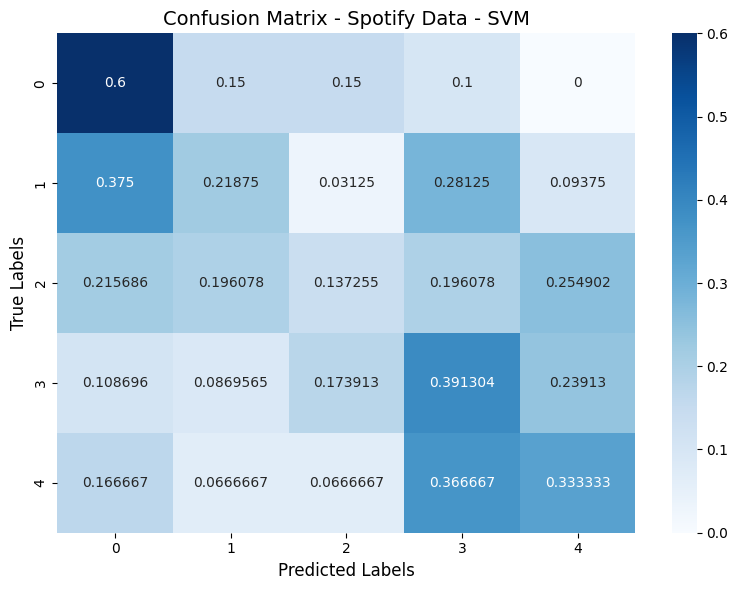

In [116]:
# Marketing Dataset
x_train, x_test, y_train, y_test = train_test_split(x_marketing, y_marketing, test_size=0.2, random_state=10)
svm_pipeline_marketing.fit(x_train, y_train) 
y_pred = svm_pipeline_marketing.predict(x_test)
# Check if the classes are correctly identified by the model
print("Classes in Marketing dataset:", svm_pipeline_marketing.classes_)

# Calculate the confusion matrix
cm_marketing = confusion_matrix(y_test, y_pred)
cmn_marketing = cm_marketing.astype('float') / cm_marketing.sum(axis=1)[:, np.newaxis]  # Normalize

# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cmn_marketing, annot=True, fmt='g', cmap='Blues', 
            xticklabels=svm_pipeline_marketing.classes_, 
            yticklabels=svm_pipeline_marketing.classes_)
plt.title('Confusion Matrix - Marketing Data - SVM', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.tight_layout()

# Save and show the plot
plt.savefig('confusion_matrix_marketing_svm.png')  # Save as PNG file 
plt.show()

# Spotify Dataset
x_train, x_test, y_train, y_test = train_test_split(x_spotify, y_spotify, test_size=0.2, random_state=10)
svm_pipeline_spotify.fit(x_train, y_train) 
y_pred = svm_pipeline_spotify.predict(x_test)
# Check if the classes are correctly identified by the model
print("Classes in Spotify dataset:", svm_pipeline_spotify.classes_)

cm_spotify = confusion_matrix(y_test, y_pred) 
cmn_spotify = cm_spotify.astype('float') / cm_spotify.sum(axis=1)[:, np.newaxis]  # Normalize

# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cmn_spotify, annot=True, fmt='g', cmap='Blues', 
            xticklabels=svm_pipeline_spotify.classes_, 
            yticklabels=svm_pipeline_spotify.classes_)
plt.title('Confusion Matrix - Spotify Data - SVM', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.tight_layout()

# Save and show the plot
plt.savefig('confusion_matrix_spotify_svm.png')  # Save as PNG file 
plt.show()


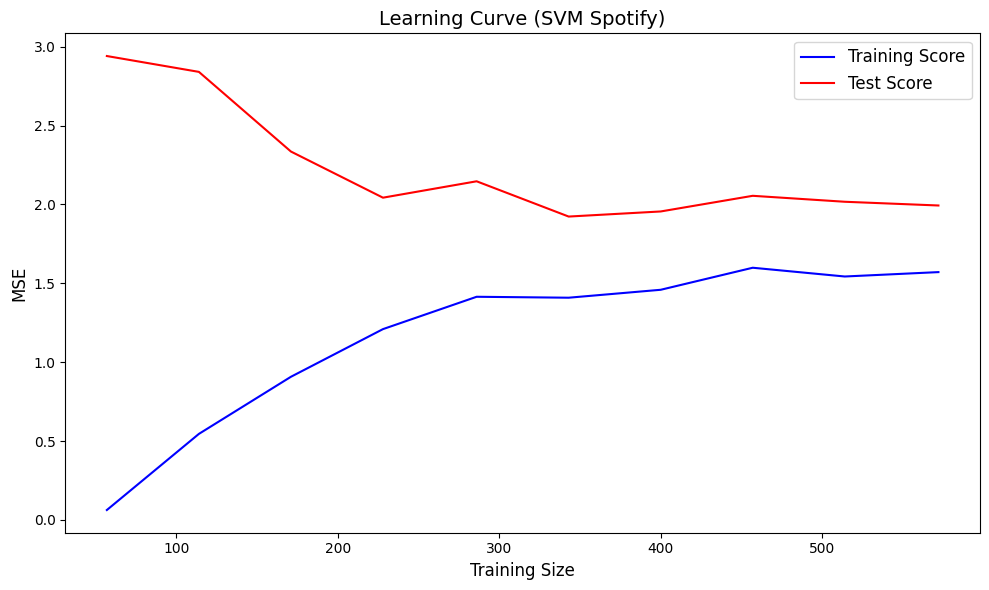

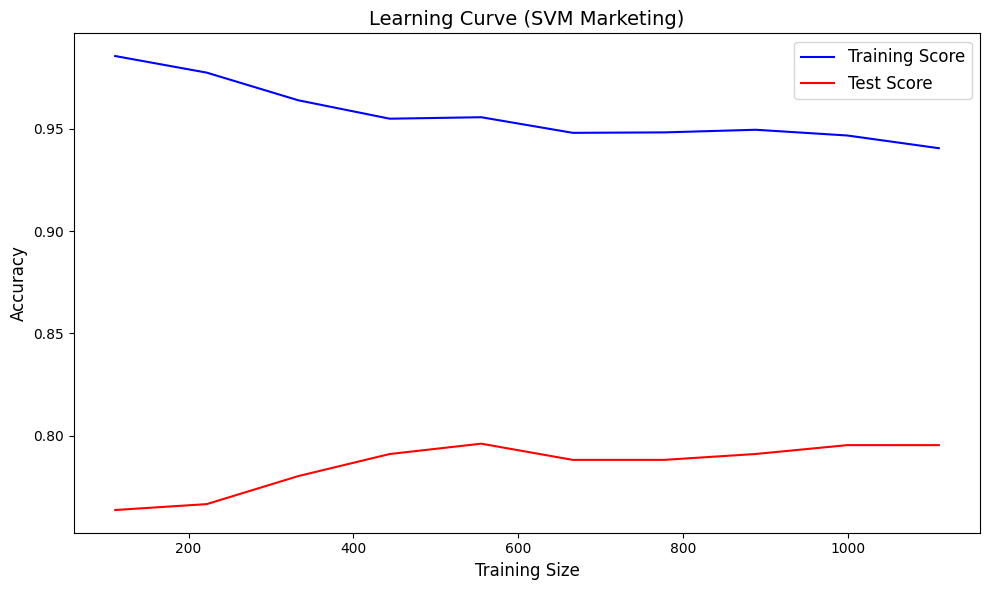

In [117]:
#Learning Curves Spotify
# 4. Use learning_curve to get training and test scores
x_train,x_test,y_train,y_test=train_test_split(x_spotify,y_spotify, test_size=0.2, random_state=10)  

train_sizes, train_scores, test_scores = learning_curve(
    svm_pipeline_spotify, x_train, y_train, 
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of training data
    scoring='neg_mean_squared_error',  # Use accuracy as the scoring metric
    n_jobs=-1  # Use all CPUs to speed up calculations
)

# 5. Calculate the mean and standard deviation of the training and test scores
train_mean = train_scores.mean(axis=1)*-1
test_mean = test_scores.mean(axis=1)*-1


# 6. Plot the learning curve
plt.figure(figsize=(10, 6))

# Plot the training and test learning curves
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Test Score', color='red')


# Add labels and title
plt.title('Learning Curve (SVM Spotify)', fontsize=14)
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend(loc='best', fontsize=12)



plt.savefig('curve_spotify_svm.png')
# Show the plot
plt.tight_layout()
plt.show()



x_train,x_test,y_train,y_test=train_test_split(x_marketing,y_marketing, test_size=0.2, random_state=10)
train_sizes, train_scores, test_scores = learning_curve(
    svm_pipeline_marketing, x_train, y_train, 
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of training data
    scoring='accuracy',  # Use accuracy as the scoring metric
    n_jobs=-1  # Use all CPUs to speed up calculations
)



# 5. Calculate the mean and standard deviation of the training and test scores
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)


# 6. Plot the learning curve
plt.figure(figsize=(10, 6))

# Plot the training and test learning curves
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Test Score', color='red')

# Add labels and title
plt.title('Learning Curve (SVM Marketing)', fontsize=14)
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()

plt.savefig('curve_marketing_svm.png')
# Show the plot
plt.tight_layout()
plt.show()